In [1]:
import pymysql
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import networkx as nx
import haversine as hs
from haversine import Unit
import datetime
import json
import geopandas as gpd
from shapely.geometry import Point, Polygon, shape
import gmplot
import folium
from folium import plugins
from folium.plugins import HeatMap

****Query the database to return all the trips in a 5 minute pickup window****

In [2]:
delay = 300.0

conn=pymysql.connect(host='127.0.0.1',port=int(3306),user='root',passwd=' ',db=' ')

df=pd.read_sql_query(
    """SELECT Lpep_pickup_datetime, lpep_dropoff_datetime ,Pickup_longitude, Pickup_latitude, Dropoff_longitude, Dropoff_latitude, Trip_distance, Passenger_count FROM green_data 
    WHERE Lpep_pickup_datetime >= '2015-01-01  01:00:00' AND Lpep_pickup_datetime <= '2015-01-01 01:05:00'
    UNION
    SELECT tpep_pickup_datetime, tpep_dropoff_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, trip_distance, passenger_count FROM yellow_data
    WHERE tpep_pickup_datetime >= '2015-01-01  01:00:00' AND tpep_pickup_datetime <= '2015-01-01 01:05:00'
    ORDER BY Lpep_pickup_datetime;""",
conn)

df = df[(df != 0).all(1)]
df['points'] = 1

****Import Manhattan geojson files and store pickup and dropoff points****

In [3]:
street_map = gpd.read_file('C:/Users/Michael/Desktop/School/CS-480/Project/geo/manhattan.geojson')
pickup_geo = [Point(xy) for xy in zip(df['Pickup_latitude'], df['Pickup_longitude'])]
dropoff_geo = [Point(xy) for xy in zip(df['Dropoff_latitude'], df['Dropoff_longitude'])]
df['Points'] = pickup_geo

****Get list of all boundary coordinates for Manhattan neighborhoods.****

In [4]:
l = []
with open('C:/Users/Michael/Desktop/School/CS-480/Project/geo/manhattan.geojson') as f:
    js = json.load(f)
coords = js['features'][0]['geometry']['coordinates'][0][0]

****Function that returns a list of True or False values if a pair of coordinates are in Manhattan****

In [5]:
def coord(geometry):
    coord_list = []
    poly = Polygon(coord_list)
    res = []
    for i in range(0, len(geometry)):
        res.append(False)

    for i in js:
        for j in js[i]:
            if type(j) is dict:
                coord = j['geometry']['coordinates'][0][0]
                coord_list = []
                for i in coord:
                    pair = (i[1],i[0])
                    coord_list.append(pair)
                poly = Polygon(coord_list)
                for i in range(0, len(geometry)):
                    if res[i]:
                        continue
                    res[i] = poly.contains(geometry[i])
    return res

In [6]:
df['Contains_pickup'] = coord(pickup_geo)
df['Contains_dropoff'] = coord(dropoff_geo)

****Remove any entries from the dataframe that don't have rides starting or ending in Manhattan****

In [7]:
df = df[df['Contains_pickup'] == True]
df = df[df['Contains_dropoff'] == True]

****Plot where all pickup points occurred in Manhattan****

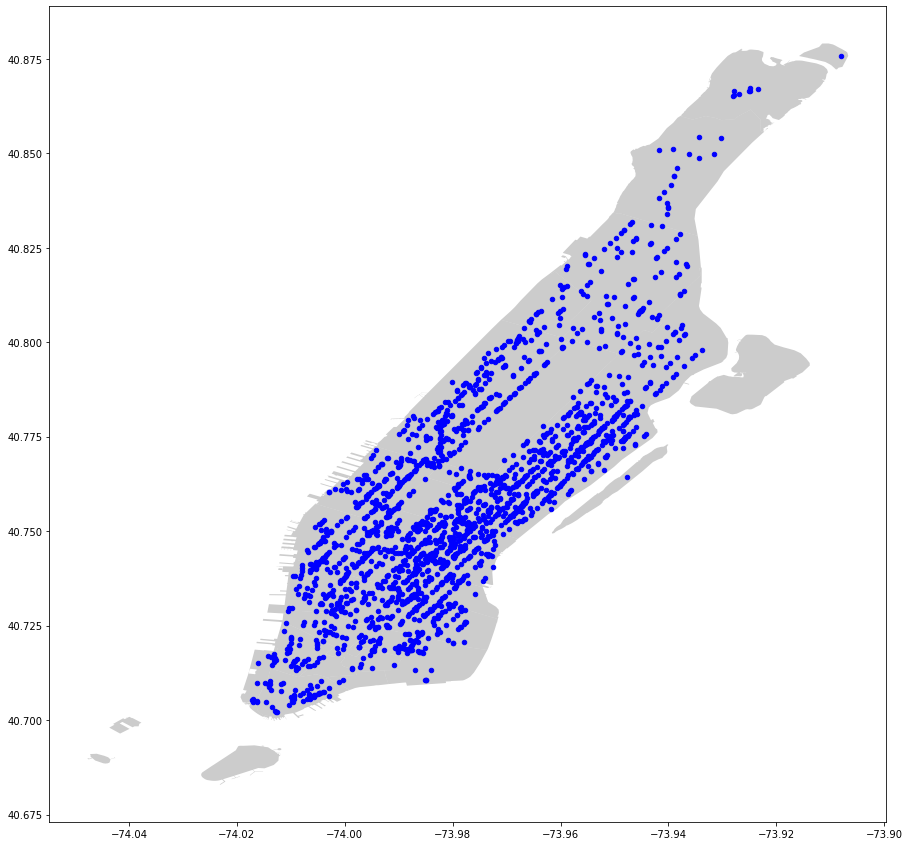

In [8]:
geometry = [Point(xy) for xy in zip(df['Pickup_longitude'], df['Pickup_latitude'])]
crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(df, crs = crs, geometry=geometry)
fig,ax = plt.subplots(figsize=(15,15))
street_map.plot(ax=ax, alpha = 0.4, color='grey')
geo_df[geo_df['points'] == 1].plot(ax=ax, markersize = 20, color = 'blue', marker = 'o')

****Calculate miles between pickup and dropoff point using haversine distance formula****

In [9]:
pickup_lon = df['Pickup_longitude'].tolist()
pickup_lat = df['Pickup_latitude'].tolist()
dropoff_lon = df['Dropoff_longitude'].tolist()
dropoff_lat = df['Dropoff_latitude'].tolist()
before_distance = []

for i in range(0, len(dropoff_lat)):
    before_distance.append(hs.haversine((pickup_lat[i], pickup_lon[i]), (dropoff_lat[i], dropoff_lon[i]), unit = Unit.MILES))

****Store this new updated distance into the dataframe for future reference, and also remove rides starting and ending at the same location****

In [10]:
df['distance'] = before_distance
df = df[df['distance'] != 0.0]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2194 entries, 2 to 3387
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Lpep_pickup_datetime   2194 non-null   datetime64[ns]
 1   lpep_dropoff_datetime  2194 non-null   datetime64[ns]
 2   Pickup_longitude       2194 non-null   float64       
 3   Pickup_latitude        2194 non-null   float64       
 4   Dropoff_longitude      2194 non-null   float64       
 5   Dropoff_latitude       2194 non-null   float64       
 6   Trip_distance          2194 non-null   float64       
 7   Passenger_count        2194 non-null   int64         
 8   points                 2194 non-null   int64         
 9   Points                 2194 non-null   object        
 10  Contains_pickup        2194 non-null   bool          
 11  Contains_dropoff       2194 non-null   bool          
 12  geometry               2194 non-null   object        
 13  dis

****Create lists of necessary dataframe columns for easier lookups and reference****

In [12]:
pickup_longitude = df['Pickup_longitude'].tolist()
pickup_latitude = df['Pickup_latitude'].tolist()
dropoff_longitude = df['Dropoff_longitude'].tolist()
dropoff_latitude = df['Dropoff_latitude'].tolist()
pickup_time= df['Lpep_pickup_datetime'].tolist()
dropoff_time = df['lpep_dropoff_datetime'].tolist()
passengers = df['Passenger_count'].tolist()
total_distance = df['distance'].tolist()
total_time = []

for i in range(0, len(dropoff_time)):
    total_time.append(int((dropoff_time[i] - pickup_time[i]).total_seconds()))

****Utilizing the folium library, create a heat map of pickup points in Manhattan to view where the most popular and possible merge positions are located.<br>https://python-visualization.github.io/folium/quickstart.html#Getting-Started<br>https://towardsdatascience.com/calculating-distance-between-two-geolocations-in-python-26ad3afe287b****

In [13]:
t_list = ["Stamen Terrain", "Stamen Toner", "Mapbox Bright"]
map_hooray = folium.Map(location=[40.783772, -73.965295],
                        tiles = "Stamen Terrain",
                        zoom_start = 12)
heat = []
for i in range(0, len(pickup_latitude)):
    heat.append([pickup_latitude[i], pickup_longitude[i]])
HeatMap(heat, radius=11, min_opacity = .5, max_zoom = 50).add_to(map_hooray)
map_hooray

****Increased efficiency of algorithm by converting previous Pandas datetime object to Python datetime object****

In [14]:
pickup_time = [x.to_pydatetime() for x in pickup_time]
dropoff_time = [x.to_pydatetime() for x in dropoff_time]

****Sequence calculator to determine if 2 rides are more efficient on their own, or more efficient when merged with a selected minute delay****

In [15]:
def sequence(p1, p2, d1, d2, a,b,c,d,taxi):
    trip1 = hs.haversine(p1, p2, unit = Unit.MILES)
    trip2 = hs.haversine(p2, d1, unit = Unit.MILES)
    trip3 = hs.haversine(d1, d2, unit = Unit.MILES)
    
    
    time1 = pickup_time[b] + datetime.timedelta(minutes=trip1/taxi)
    time2 = dropoff_time[c] + datetime.timedelta(minutes=trip2/taxi)
    time3 = dropoff_time[d] + datetime.timedelta(minutes=trip3/taxi) 
    
    res = trip1 + trip2 + trip3
    
    if abs(time1 - pickup_time[b]).total_seconds() >= delay:
        return (res, False)
    elif abs(time2 - dropoff_time[c]).total_seconds() >= delay:
        return (res, False)
    elif abs(time3 - dropoff_time[d]).total_seconds() >= delay:
        return (res, False)
    
    return (trip1+trip2+trip3, True)

****Implemented possible merging algorithm that was given to us in the Appendix of the project description. If two rides are possible to be merged, store the index of one trip in a map as the key and the other trip index along with the total driven miles in a list associated with that key****

In [16]:
%%time
trips = {}
G = nx.Graph()
for i in range(0, len(pickup_longitude)):
    
    if passengers[i] >= 3:
        continue
        
    t1_pickup = (pickup_longitude[i], pickup_latitude[i])
    t1_dropoff = (dropoff_longitude[i], dropoff_latitude[i])
    
    d1 = hs.haversine(t1_pickup, t1_dropoff, unit = Unit.MILES)
    
    if d1 == 0.0:
        continue
        
    s1 = d1/(total_time[i]/60)
    
    for j in range(i, len(pickup_longitude)):
        
        if passengers[i] + passengers[j] > 3:
            continue
            
        if i == j:
            continue
            
        t2_pickup = (pickup_longitude[j], pickup_latitude[j])
        t2_dropoff = (dropoff_longitude[j], dropoff_latitude[j])
        d2 = hs.haversine(t2_pickup, t2_dropoff, unit = Unit.MILES)

        if d2 == 0.0:
            continue

        s2 = d2/(total_time[j]/60)

        taxi = (s1+s2)/ 2.0
        
        seq1 = sequence(t1_pickup, t2_pickup, t1_dropoff, t2_dropoff,i,j,i,j,taxi)
        seq2 = sequence(t1_pickup, t2_pickup, t2_dropoff, t1_dropoff,i,j,j,i,taxi)
        seq3 = sequence(t2_pickup, t1_pickup, t1_dropoff, t2_dropoff,j,i,i,j,taxi)
        seq4 = sequence(t2_pickup, t1_pickup, t2_dropoff, t1_dropoff,j,i,j,i,taxi)

        curr_distance = d1 + d2
        curr_min = 1000000
        merged_trip = ()
        flag = 0
        
        if seq1[0] < curr_distance and seq1[1]:
            if seq1[0] < curr_min:
                curr_min = seq1[0]
                
        if seq2[0] < curr_distance and seq2[1]: 
            if seq2[0] < curr_min:
                curr_min = seq2[0]
                
        if seq3[0] < curr_distance and seq3[1]:
            if seq3[0] < curr_min:
                curr_min = seq3[0]
                
        if seq4[0] < curr_distance and seq4[1]:
            if seq4[0] < curr_min:
                curr_min = seq4[0]
                
        if curr_min != 1000000:
            if i in trips:
                trips[i].append((j,curr_min))
            else:
                trips[i] =[(j,curr_min)]
        

Wall time: 1min 31s


****Create a graph based off of the possible merged trips. The nodes are the indices of the trips and edges are connected only if they have a possibility to be merged. Edge weights are the miles it would take to complete the merged trip.****

In [17]:
for i in trips:
    for j in trips[i]:
        G.add_edge(i, j[0], weight=j[1])

****Run the maximum weight matching algorithm. I used the off the shelf built in max_weight_matching function given in the NetworkX library. https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.matching.max_weight_matching.html****

In [18]:
%%time
merged = nx.max_weight_matching(G, maxcardinality=True)

Wall time: 24 s


****Math to determine the total amount of miles before the algorithm run, how many miles are going to be driven after the maximum matching algorithm, and the difference. <br>1) Create a set with all trip indices.<br>2) Loop through the result from the maximim matching algorithm summing up miles, and remove indices from set.<br>3) Only indices left in set are now trips that were not merged with another, loop through and add these trips distance to the total.****

In [19]:
merged_distance = 0.0
already_matched = set()

# Create a set of ALL trip indices
for i in range(0, len(total_distance)):
    already_matched.add(i)

# Remove the two merged trips indices from the set of all indices
# Find distance between these two merged indices from previous map
# Add that distance found between them to running total
for i in merged:
    already_matched.remove(i[0])
    already_matched.remove(i[1])
    if i[0] < i[1]:
        trip = trips[i[0]]
        search = i[1]
    else:
        trip = trips[i[1]]
        search = i[0]
    for j in trip:
        if j[0] == search:
            merged_distance += j[1]

# At this point, the only trips left in the set are trips that were NOT merged
# Simply add the distance from the lonesome trip to the running total
for i in already_matched:
    merged_distance += total_distance[i]

print('After Merging Distance: {:.2f} miles'.format(merged_distance))
print('Original Distance: {:.2f} miles'.format(sum(total_distance)))
print('Total Miles Saved: {:.2f} miles'.format(sum(total_distance)-merged_distance))
print('Percentage of Miles Saved: {:.2f}%'.format(100*(1.0-merged_distance/sum(total_distance))))

After Merging Distance: 3368.25 miles
Original Distance: 3810.00 miles
Total Miles Saved: 441.75 miles
Percentage of Miles Saved: 11.59%
